In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random

Big idea: Create clusters that are class-discriminative (clusters of points with known class are discriminative).

How? Modify distance function. Distance between points is $\infty$ if their class does not match.

In [2]:
class DiscriminativeKMeans:

    def __init__(self, k_vals: list, maxiter=100, tol=1e-5):
        """Create a DiscriminativeKMeans Clusterer.

        Args:
            k_vals (list(int)): Specifies how many clusters to form for each unique class in the data.
            maxiter (int): Maximum number of iterations to fit for
            tol (float): Threshold for convergence
        """
        self.k_vals = k_vals    # Each k specifies how many clusters to form for each unique class.
        self.maxiter = maxiter
        self.tol = tol

    def fit(self, data: np.ndarray):
        """Compute discriminative cluster centers for all data.
        
        After running this function, DiscriminativeKMeans will have an attribute `self.cluster_assignments`
        that stores index-wise cluster assignments for all data (index matching row that data point lives in).

        Args:
            data (np.ndarray): A 2D numpy array with the data. Last column should indicate class.
        Returns:
            self
        """
        unique_classes = np.unique(data[:, -1])

        # Each entry of k_vals specifies how many random centers to pick having class i.
        centers = []
        for i, k in enumerate(self.k_vals):
            centers.extend(random.choices(data[data[:, -1] == i], k=k))
        
        centers = np.array(centers)
        cluster_assignments = np.zeros(len(data))
    
        for _ in range(self.maxiter):
                    
            # Assign each point to a cluster.
            for i, point in enumerate(data):
                distance_to_centers = [np.inf if center[-1] != point[-1] else np.linalg.norm(center[:-1] - point[:-1])
                                        for center in centers]
                cluster_assignments[i] = np.argmin(distance_to_centers)

            new_centers = np.zeros_like(centers)

            # Compute new centers.
            for i in range(sum(self.k_vals)):
                new_centers[i, :] = np.mean(data[cluster_assignments == i], axis=0)
              
            # Check for convergence.
            diff_from_last_iteration = np.linalg.norm(centers - new_centers)

            print(f"Normed difference from last iteration: {diff_from_last_iteration}")

            if diff_from_last_iteration < self.tol:
                break
                        
            centers = new_centers
                
        self.centers = new_centers
        self.cluster_assignments = cluster_assignments
        
        return self

Normed difference from last iteration: 1.3634148304899725
Normed difference from last iteration: 0.0
[0. 0. 0. 2. 2. 3. 1. 1. 1. 1. 1. 1. 1. 3. 3. 2.]


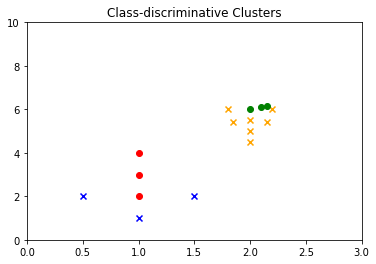

In [6]:
# Toy dataset

classes = [0, 1]
toy_data = np.array([
    [1, 1, 0],
    [1/2, 2, 0],
    [3/2, 2, 0],
    [1, 2, 1],
    [1, 3, 1],
    [2, 6, 1],
    [2, 5, 0],
    [2, 5.5, 0],
    [2, 4.5, 0],
    [2.2, 6, 0],
    [2.15, 5.4, 0],
    [1.85, 5.4, 0],
    [1.8, 6, 0],
    [2.1, 6.1, 1],
    [2.15, 6.16, 1],
    [1, 4, 1],
])

clusterer = DiscriminativeKMeans(k_vals=[2, 2])

cluster_assignments = clusterer.fit(toy_data).cluster_assignments

print(cluster_assignments)

cluster_0 = toy_data[cluster_assignments == 0, :-1]
cluster_1 = toy_data[cluster_assignments == 1, :-1]
cluster_2 = toy_data[cluster_assignments == 2, :-1]
cluster_3 = toy_data[cluster_assignments == 3, :-1]

plt.scatter(cluster_0[:, 0], cluster_0[:, 1], c='blue', marker='x')
plt.scatter(cluster_1[:, 0], cluster_1[:, 1], c='orange', marker='x')
plt.scatter(cluster_2[:, 0], cluster_2[:, 1], c='red', marker='o')
plt.scatter(cluster_3[:, 0], cluster_3[:, -1], c='green', marker='o')
plt.xlim(0, 3)
plt.ylim(0, 10)
plt.title("Class-discriminative Clusters")
plt.show()

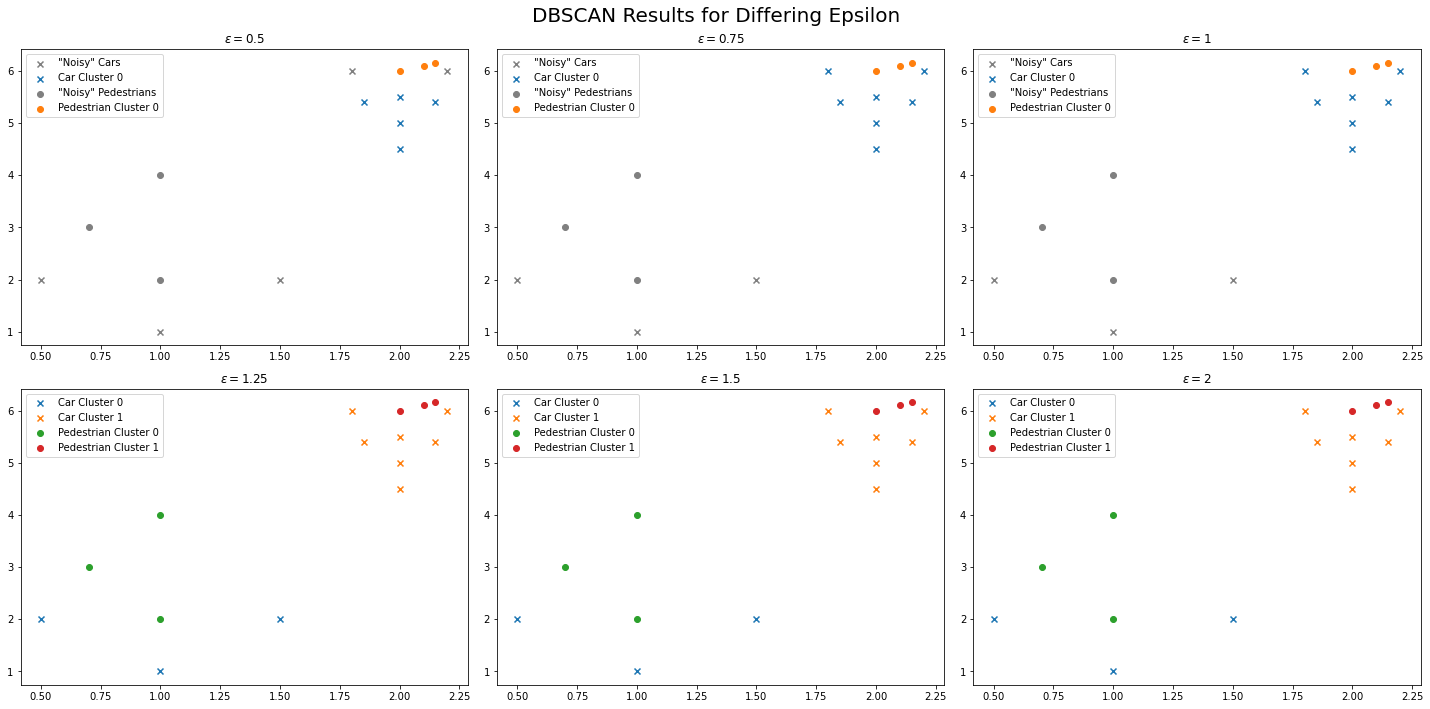

In [38]:
# Try DBScan passing in one class at a time.
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

# Last column indicates class.
toy_data = np.array([
    [1, 1, 0],
    [1/2, 2, 0],
    [3/2, 2, 0],
    [1, 2, 1],
    [.7, 3, 1],
    [2, 6, 1],
    [2, 5, 0],
    [2, 5.5, 0],
    [2, 4.5, 0],
    [2.2, 6, 0],
    [2.15, 5.4, 0],
    [1.85, 5.4, 0],
    [1.8, 6, 0],
    [2.1, 6.1, 1],
    [2.15, 6.16, 1],
    [1, 4, 1],
])

# Get data for cars and pedestrians so we can cluster separately.
toy_data_cars = toy_data[toy_data[:, -1] == 0][:, :-1]
toy_data_pedestrians = toy_data[toy_data[:, -1] == 1][:, :-1]

epsilon_vals = [0.5, 0.75, 1, 1.25, 1.5, 2]

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle("DBSCAN Results for Differing Epsilon", fontsize=20)

for ax, eps in zip(axs.ravel(), epsilon_vals):

    ax.set_title(f"$\epsilon = {eps}$")

    car_dbscan = DBSCAN(eps=eps, min_samples=3)
    pedestrian_dbscan = DBSCAN(eps=eps, min_samples=3)

    car_labels = car_dbscan.fit(toy_data_cars).labels_
    pedestrian_labels = pedestrian_dbscan.fit(toy_data_pedestrians).labels_

    for cluster_label in np.unique(car_labels):
        
        is_noisy_cluster = cluster_label == -1
        cars_in_cluster = toy_data_cars[car_labels == cluster_label]

        if not is_noisy_cluster:
            ax.scatter(*cars_in_cluster.T, marker='x', label=f"Car Cluster {cluster_label}")
        else:
            ax.scatter(*cars_in_cluster.T, marker='x', c='grey', label=f"\"Noisy\" Cars")

    for cluster_label in np.unique(pedestrian_labels):

        is_noisy_cluster = cluster_label == -1
        pedestrians_in_cluster = toy_data_pedestrians[pedestrian_labels == cluster_label]

        if not is_noisy_cluster:
            ax.scatter(*pedestrians_in_cluster.T, marker='o', label=f"Pedestrian Cluster {cluster_label}")
        else:
            ax.scatter(*pedestrians_in_cluster.T, marker='o', c='grey', label=f"\"Noisy\" Pedestrians")

    ax.legend()

plt.tight_layout()
plt.show()

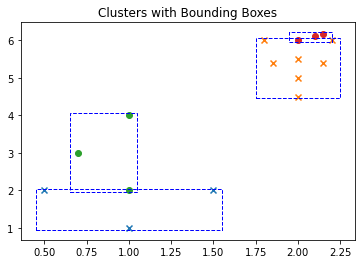

In [53]:
from matplotlib.patches import Rectangle


# Draw bounding boxes.
eps = 1.25
buffer = 0.05

car_dbscan = DBSCAN(eps=eps, min_samples=3)
pedestrian_dbscan = DBSCAN(eps=eps, min_samples=3)

car_labels = car_dbscan.fit(toy_data_cars).labels_
pedestrian_labels = pedestrian_dbscan.fit(toy_data_pedestrians).labels_

fig, ax = plt.subplots()
ax.set_title("Clusters with Bounding Boxes")

for cluster_label in np.unique(car_labels[car_labels != -1]):

    cluster_data = toy_data_cars[car_labels == cluster_label]
    min_x, min_y  = cluster_data.min(axis=0)
    max_x, max_y = cluster_data.max(axis=0)

    ax.add_patch(Rectangle(xy=(min_x - buffer, min_y - buffer), width=(max_x - min_x) + 2 * buffer, height=(max_y - min_y) + 2* buffer, fc='none', color='blue', lw=1, ls='--'))
    ax.scatter(*cluster_data.T, marker='x')
    

for cluster_label in np.unique(pedestrian_labels[pedestrian_labels != -1]):

    cluster_data = toy_data_pedestrians[pedestrian_labels == cluster_label]
    min_x, min_y  = cluster_data.min(axis=0)
    max_x, max_y = cluster_data.max(axis=0)

    ax.add_patch(Rectangle(xy=(min_x - buffer, min_y - buffer), width=(max_x - min_x) + 2 * buffer, height=(max_y - min_y) + 2 * buffer, fc='none', color='blue', lw=1, ls='--'))
    ax.scatter(*cluster_data.T, marker='o')
    
ax.scatter(*toy_data_cars[car_labels == -1].T, c='grey', marker='x')
ax.scatter(*toy_data_pedestrians[pedestrian_labels == -1].T, c='grey', marker='o')

plt.show()

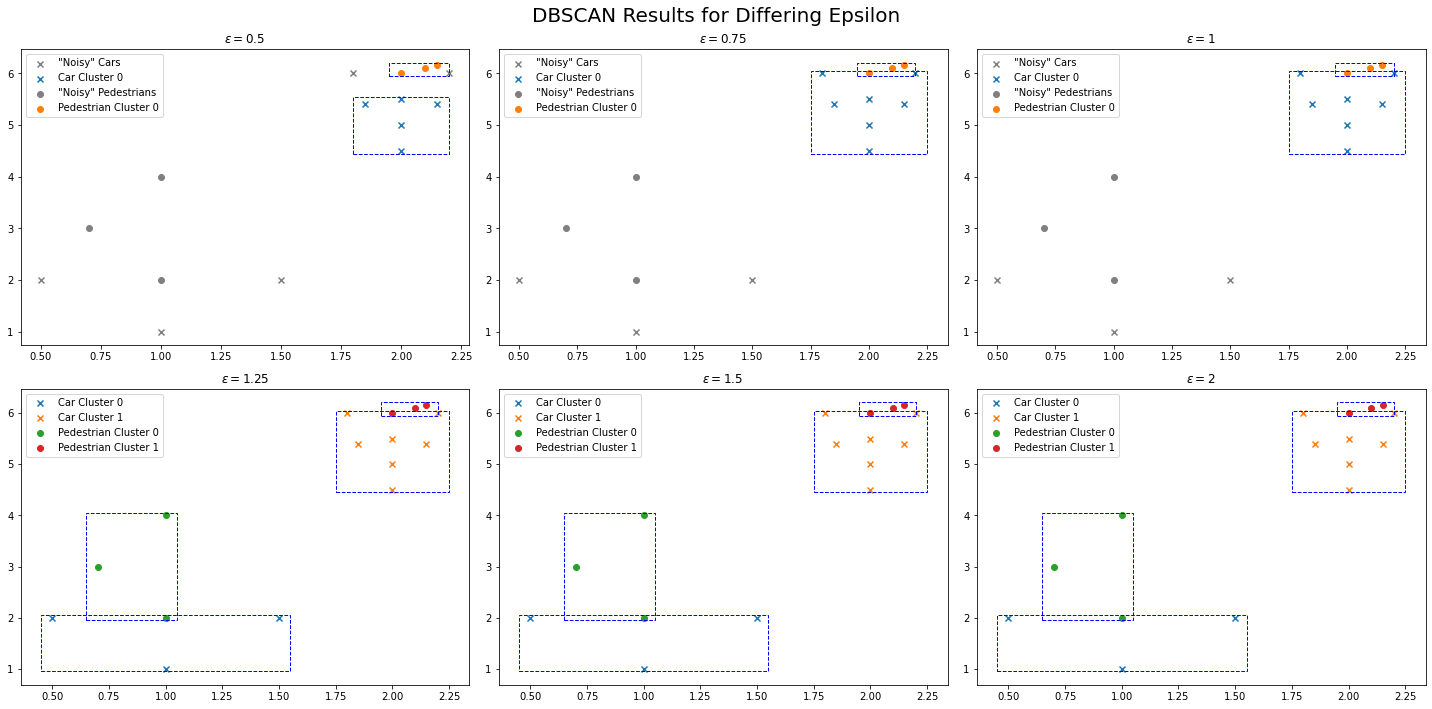

In [55]:
# Putting it all together.

epsilon_vals = [0.5, 0.75, 1, 1.25, 1.5, 2]
buffer = 0.05

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle("DBSCAN Results for Differing Epsilon", fontsize=20)

for ax, eps in zip(axs.ravel(), epsilon_vals):

    ax.set_title(f"$\epsilon = {eps}$")

    car_dbscan = DBSCAN(eps=eps, min_samples=3)
    pedestrian_dbscan = DBSCAN(eps=eps, min_samples=3)

    car_labels = car_dbscan.fit(toy_data_cars).labels_
    pedestrian_labels = pedestrian_dbscan.fit(toy_data_pedestrians).labels_

    for cluster_label in np.unique(car_labels):
        
        is_noisy_cluster = cluster_label == -1
        cars_in_cluster = toy_data_cars[car_labels == cluster_label]

        min_x, min_y  = cars_in_cluster.min(axis=0)
        max_x, max_y = cars_in_cluster.max(axis=0)

        if not is_noisy_cluster:
            ax.scatter(*cars_in_cluster.T, marker='x', label=f"Car Cluster {cluster_label}")
            ax.add_patch(Rectangle(xy=(min_x - buffer, min_y - buffer), width=(max_x - min_x) + 2 * buffer, height=(max_y - min_y) + 2* buffer, fc='none', color='blue', lw=1, ls='--'))
        else:
            ax.scatter(*cars_in_cluster.T, marker='x', c='grey', label=f"\"Noisy\" Cars")

    for cluster_label in np.unique(pedestrian_labels):

        is_noisy_cluster = cluster_label == -1
        pedestrians_in_cluster = toy_data_pedestrians[pedestrian_labels == cluster_label]

        min_x, min_y  = pedestrians_in_cluster.min(axis=0)
        max_x, max_y = pedestrians_in_cluster.max(axis=0)

        if not is_noisy_cluster:
            ax.scatter(*pedestrians_in_cluster.T, marker='o', label=f"Pedestrian Cluster {cluster_label}")
            ax.add_patch(Rectangle(xy=(min_x - buffer, min_y - buffer), width=(max_x - min_x) + 2 * buffer, height=(max_y - min_y) + 2* buffer, fc='none', color='blue', lw=1, ls='--'))
        else:
            ax.scatter(*pedestrians_in_cluster.T, marker='o', c='grey', label=f"\"Noisy\" Pedestrians")

    ax.legend()

plt.tight_layout()
plt.show()